In [7]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.signal
import pandas as pd
import IPython.display as ipd
import matplotlib.colors as mcolors
import scipy.stats as stats
from scipy.io import wavfile
import librosa
import wave


In [10]:
SAMPLE_RATE = 20000
data_dir = '../data/'

data_file_list = glob(data_dir + '*.wav')
data_file_list[0]

'../data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav'

In [9]:
ipd.Audio(data_file_list[0])

## Reading and Plotting the Raw Neural Data Using the Wave Python Library

input_wav.getframerate() [Sample Rate]: 19531
input_wav.getnframes() [Number of Samples]: 98699
sample_bytes: b'\xa0\xfe`\xfe\xe0\xfe\xe0\xfe`\xff`\x02_\x00`\xff\xdf\x00\xdf\x00\xdf\x01\xa0\x04\xe0\x04`\x03\xe0\x02 \x05\xe0\x04`\x05\xe0\x04\xe0\x02\xa0\x02`\x05`\x04`\x05\xe1\x06\xe1\x06\xa1\x07\xa1\x06a\x07!\x07 \x05 \x05\xe0\x05`\x05\xe0\x05\xa1\x06\xa1\x08!\t!\t\xe1\t\xa2\x0c\xa2\n\xa1\t\xe1\x07a\x08\xa1\x08\xe1\x06!\x06\xa1\t!\n\xa1\x07!\x08!\x06\xa0\x05\xe0\x05`\x05`\x05`\x04\xe0\x04\xa1\x06\xe1\x07\xe1\x06!\x06a\x06!\x07 \x05\xdf\x01\xdf\x00\x9f\x01\xdf\x01\xa0\x02\xa0\x04!\x06\xe1\x07\xe0\x05\xa1\x06a\x06\xe0\x04\xe0\x05\xa0\x04\xe0\x04\xe0\x04\xa1\x06\xe1\x08\xa1\x06!\x06\xa1\x07\xa0\x04\xe0\x03\xe0\x02\xa0\x03a\x06\xe1\x06!\x06\xe0\x04\xe0\x05\xe1\x06\xa1\x06!\x06`\x04\xe0\x03 \x04\xa0\x02\xa0\x02_\x00`\xff\x1f\x00`\xff`\x03 \x05\xa0\x03\xe0\x02\xa0\x02\x9f\x00\xe0\xfe\x1f\x00_\x00\xdf\x00\x9f\x01`\x02\xdf\x00\xa0\xfe\x9f\x00 \xff\xe0\xfe\x9f\x00\x9f\x00_\x01`\x02\x9f\x01\x9f\x

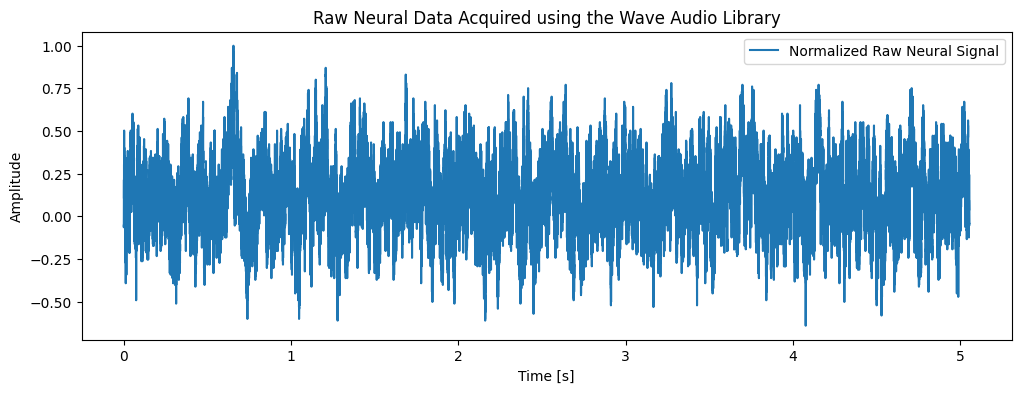

In [12]:
input_wav = wave.open(data_file_list[0], 'rb')

print(f'input_wav.getframerate() [Sample Rate]: {input_wav.getframerate()}')
print(f'input_wav.getnframes() [Number of Samples]: {input_wav.getnframes()}')

sample_bytes = input_wav.readframes(input_wav.getnframes())
print(f'sample_bytes: {sample_bytes}')

# Calculating the time of the raw neural signal
time_endpoint = input_wav.getnframes() / input_wav.getframerate()
time_array = np.arange(start=0, stop=time_endpoint,
                       step=(1/input_wav.getframerate()))

signal_array = np.frombuffer(sample_bytes, dtype=np.int16)

# Normalizing the Array between -1 and 1
signal_array_normalized = signal_array / signal_array.max()

print(f'len(signal_array): {len(signal_array)}')
print(f'len(time_array): {len(time_array)}')

plt.figure(figsize=(12, 4))
plt.plot(time_array, signal_array_normalized)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Raw Neural Data Acquired using the Wave Audio Library')
plt.legend(['Normalized Raw Neural Signal'])
plt.show()

In [13]:
type(input_wav)

wave.Wave_read

## Reading and Plotting the Raw Neural Data using the Librosa Library

Sample Rate From Librosa: 19531
len(raw_neural_data_bytes): 394796


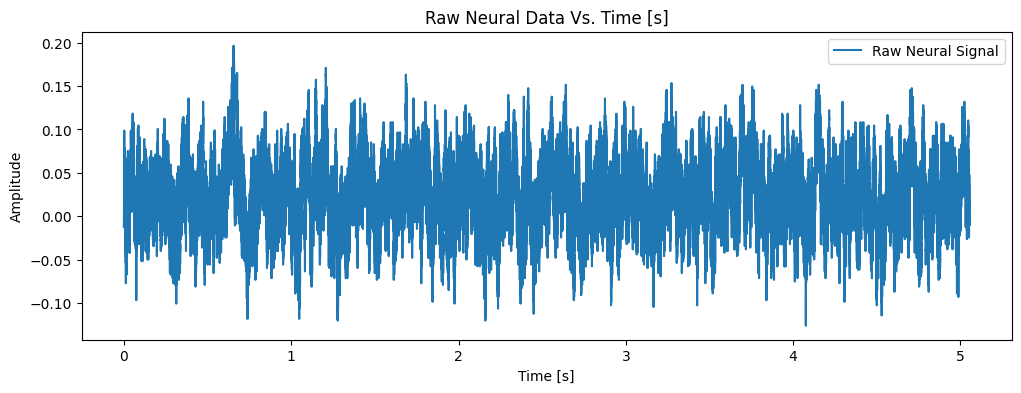

In [14]:
SAMPLE_RATE = 19531
raw_neural_data, sr = librosa.load(data_file_list[0], sr = SAMPLE_RATE)
print(f'Sample Rate From Librosa: {sr}')
raw_neural_data_bytes = raw_neural_data.tobytes()
print(f'len(raw_neural_data_bytes): {len(raw_neural_data_bytes)}')

stop_time = len(raw_neural_data) / SAMPLE_RATE
time = np.arange(0, stop_time, step=(1/SAMPLE_RATE))

plt.figure(figsize=(12, 4))
plt.plot(time, raw_neural_data)
plt.title('Raw Neural Data Vs. Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(['Raw Neural Signal'])
plt.show()

## Reading and plotting the Raw Neural Data using SciPy

In [15]:
filePath = data_file_list[0]
with open(filePath, 'rb') as file_to_read:
    wav_bytes = file_to_read.read()
file_to_read.close()

print(f'type(scipy_wav_obj): {type(wav_bytes)}')
scipy_signal_amplitude = np.frombuffer(wav_bytes, dtype=np.int16)
print(f'len(scipy_signal_amplitude): {len(scipy_signal_amplitude)}')

type(scipy_wav_obj): <class 'bytes'>
len(scipy_signal_amplitude): 98721


In [16]:
wavfile.read(data_file_list[0])

(19531, array([-352, -416, -288, ...,  287,  223, -288], dtype=int16))

## Comparing Methods of Reading the Audio Data Including SciPy, Wave, & Librosa

Comparing Array Size:
Librosa loading of data: len(raw_neural_data): 98699
SciPy loading of data: len(raw_audio_array_scipy): 98699
Wave loading of data: len(signal_array): 98699


Comparing Sample Rates:
Sample Rate Librosa: 19531
Sample Rate SciPy: 19531
Sample Rate Wave: 19531


Time in seconds of the raw audio from scipy: 5.0534534842045975


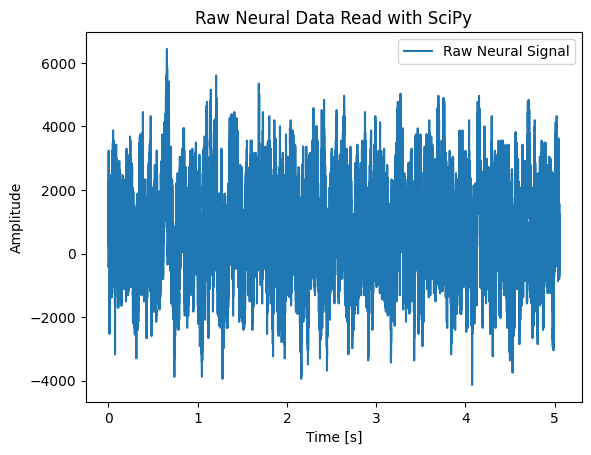

In [17]:
# Testing SciPy
sample_rate_scipy, raw_audio_array_scipy = wavfile.read(data_file_list[0])

# Comparing Array Size
print(f'Comparing Array Size:')
print(f'Librosa loading of data: len(raw_neural_data): {len(raw_neural_data)}')
print(f'SciPy loading of data: len(raw_audio_array_scipy): {len(raw_audio_array_scipy)}')
print(f'Wave loading of data: len(signal_array): {len(signal_array)}')

print('\n')

# Comparing Sample Rates
print(f'Comparing Sample Rates:')
print(f'Sample Rate Librosa: {sr}')
print(f'Sample Rate SciPy: {sample_rate_scipy}')
print(f'Sample Rate Wave: {input_wav.getframerate()}')

print('\n')

# Plotting the Raw Neural Data read with SciPy
time_end = len(raw_audio_array_scipy) / sample_rate_scipy 
print(f'Time in seconds of the raw audio from scipy: {time_end}')

time_raw_audio_array_scipy = np.arange(start=0, stop=time_end, 
                                       step=(1/sample_rate_scipy))

len(time_raw_audio_array_scipy)

plt.plot(time_raw_audio_array_scipy, raw_audio_array_scipy)
plt.title('Raw Neural Data Read with SciPy')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(['Raw Neural Signal'])
plt.show()

## Detrending the Signal of the Raw Neural Data

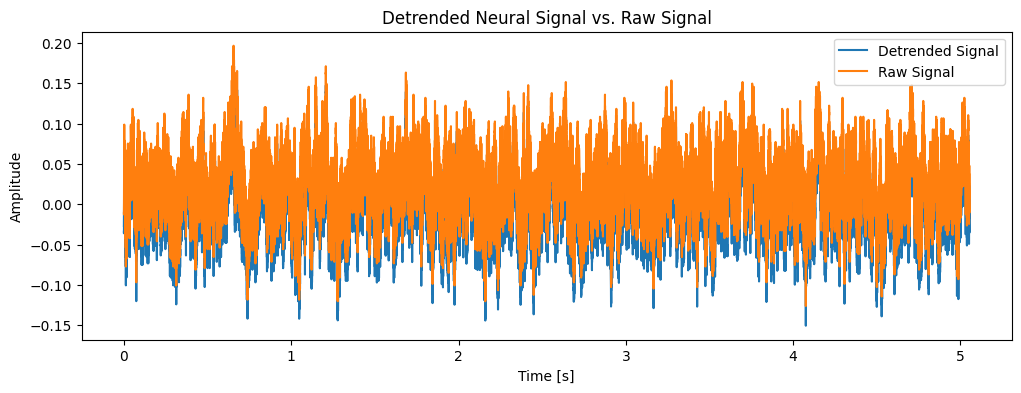

In [18]:
# It appears there is a trend in the data that is non-zero
detrend_y = scipy.signal.detrend(raw_neural_data)

# Plotting the Detrended Signal
plt.figure(figsize=(12, 4))
plt.plot(time, detrend_y, label='Detrended Signal')
plt.plot(time, raw_neural_data, label='Raw Signal')
plt.title('Detrended Neural Signal vs. Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Frequency Analysis of Raw Neural Data

In [19]:
FFT = np.fft.fft(detrend_y)
half_length_of_the_FFT = int(len(FFT)/2)

# Creating frequency bins
N = len(FFT)

freq_bins = np.arange(start=0, stop=(sr/2), step=(sr/N))

In [20]:
len(freq_bins) == int(len(FFT)/2)

False

In [21]:
psd = FFT * np.conj(FFT)/ len(FFT)

In [22]:
psd = psd[0:len(psd)//2]

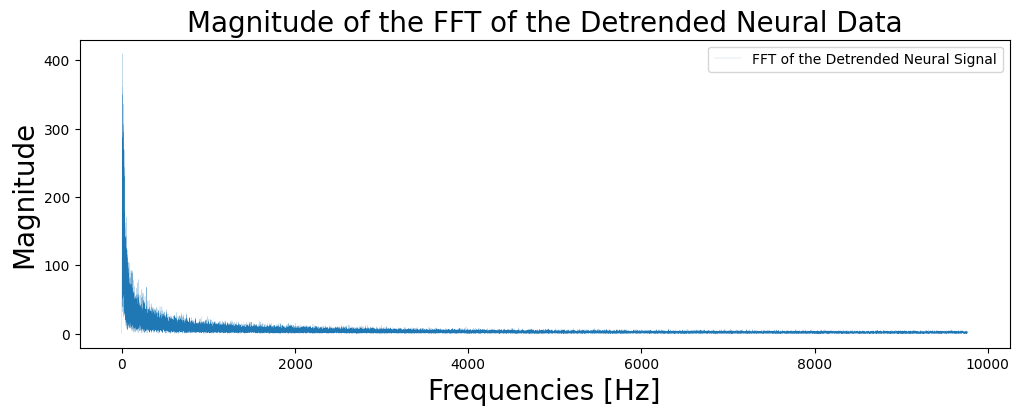

In [23]:
# Plot the Frequency Domain Transform of the Detrended Neural Data
plt.figure(figsize=(12,4))
plt.plot(freq_bins[0:len(freq_bins)-1], abs(FFT[0:len(FFT)//2]), 
         label='FFT of the Detrended Neural Signal', linewidth=.1)
plt.title('Magnitude of the FFT of the Detrended Neural Data', fontsize=20)
plt.xlabel('Frequencies [Hz]', fontsize=20)
plt.ylabel('Magnitude', fontsize=20)
plt.legend()
plt.show()

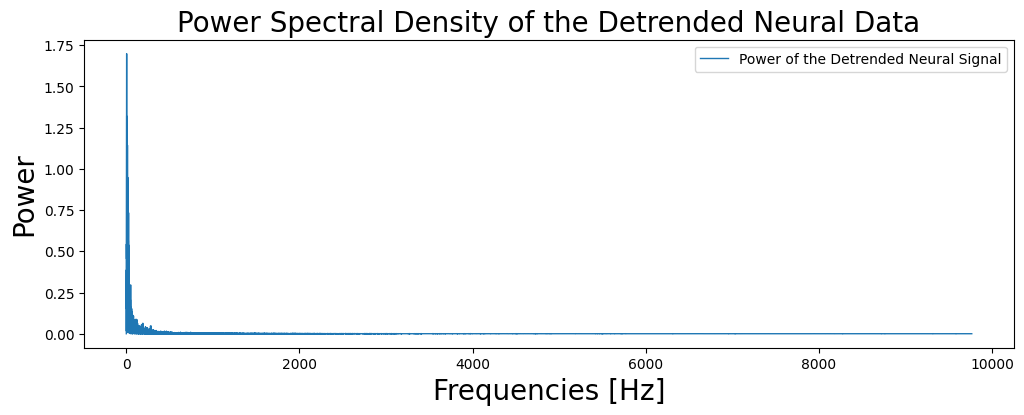

In [25]:
# Plot of the PSD of the Detrended Neural Data
plt.figure(figsize=(12,4))
plt.plot(freq_bins[0:len(freq_bins)-1], psd, 
         label='Power of the Detrended Neural Signal', linewidth=1)
plt.title('Power Spectral Density of the Detrended Neural Data', fontsize=20)
plt.xlabel('Frequencies [Hz]', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.legend()
plt.show()


In [26]:
# Sorting the peaks and printing the corresponding indices:
freq_amplitudes = abs(FFT[0:int(len(FFT)/2)])
freq_amplitudes_df = pd.DataFrame(freq_amplitudes, columns = ['Amplitude'])
freq_amplitudes_df_sorted = freq_amplitudes_df.sort_values(by='Amplitude', ascending=False).head(20)

In [27]:
freq_amplitudes_df_sorted.head()

,Amplitude
21,409.473232
22,361.093033
35,349.627481
68,336.017804
27,335.555398


In [29]:
def fft_filter_custom(percentage, freq_bins, FFT):
    threshold = percentage * (2 * abs(FFT[0:len(FFT)//2]) / len(freq_bins)).max()
    print(f"threshold: {threshold}")
    filtered_FFT = FFT.copy()
    filtered_FFT_mag = np.abs(filtered_FFT)
    filtered_FFT_mag = 2*filtered_FFT_mag / len(freq_bins)
    filtered_FFT[filtered_FFT_mag <= threshold]=0
    return filtered_FFT

# Plotting the thresholded FFT
percentage = 0.25

fft_filtered_custom = fft_filter_custom(percentage, freq_bins, FFT)
time_filtered_custom = np.fft.ifft(fft_filtered_custom)




threshold: 0.00414866496413361


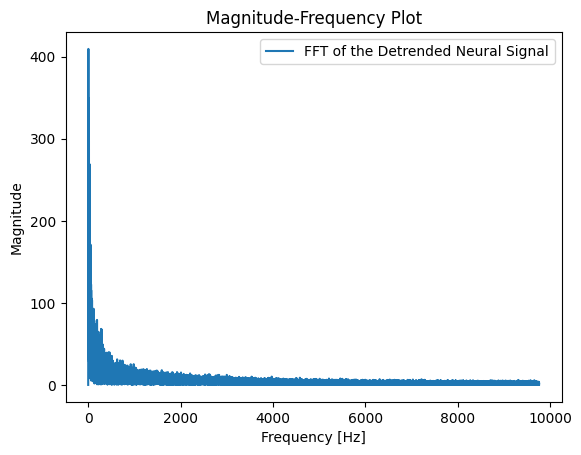

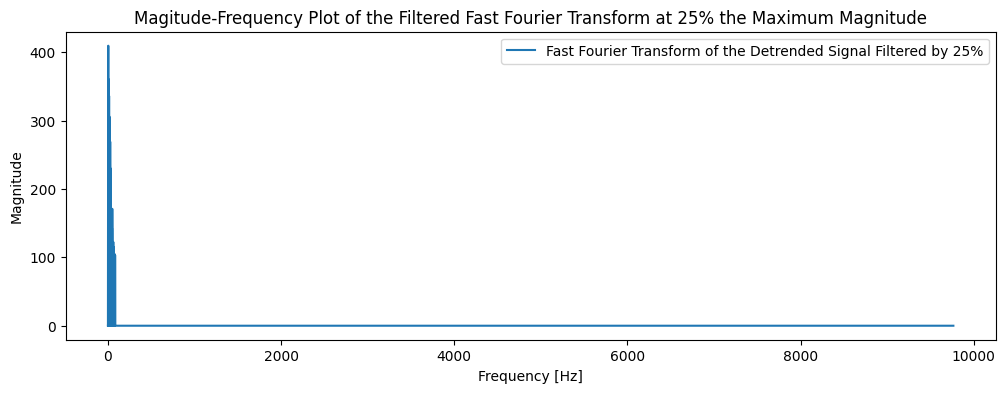

/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


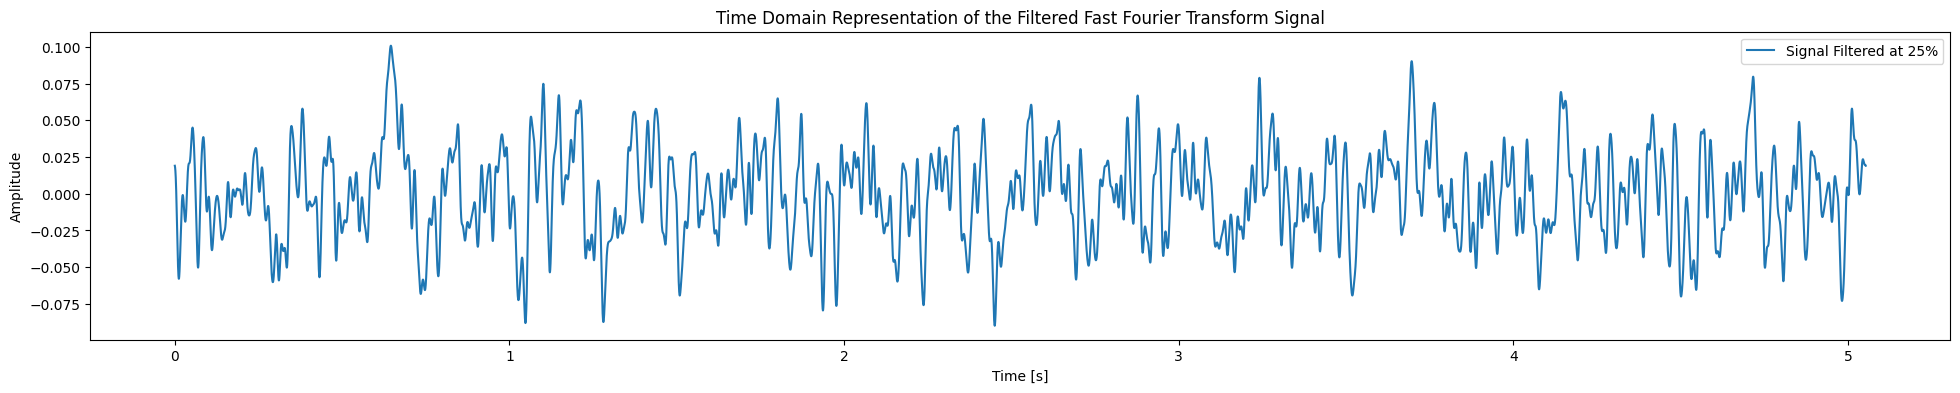

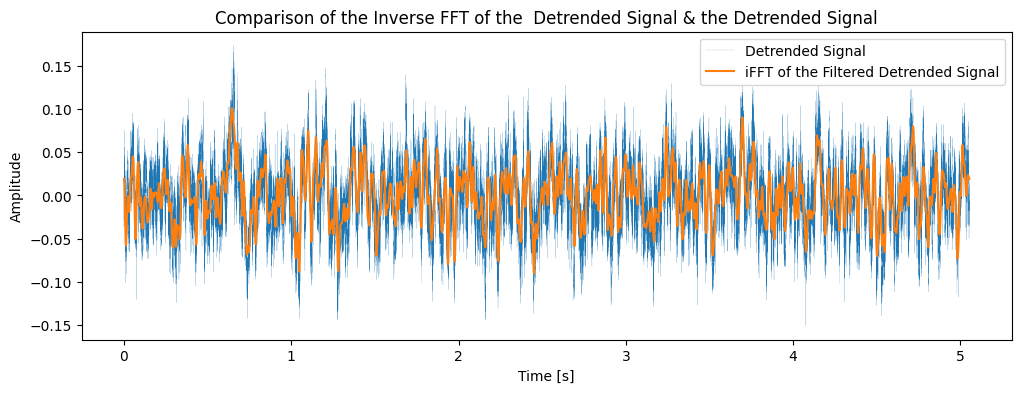

In [30]:
plt.plot(freq_bins[0:len(freq_bins)-1], abs(FFT[0:len(FFT)//2]))
plt.title('Magnitude-Frequency Plot')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend(['FFT of the Detrended Neural Signal'])
plt.show()

# Magnitude-Frequency Plot of the Filtered Signal
plt.figure(figsize=(12, 4))
plt.plot(freq_bins[0:len(freq_bins)-1], np.abs(fft_filtered_custom[0:len(fft_filtered_custom)//2]))
plt.title('Magitude-Frequency Plot of the Filtered Fast Fourier Transform at %0.0f%% the Maximum Magnitude'% (percentage*100))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend(['Fast Fourier Transform of the Detrended Signal Filtered by %0.0f%%'% (percentage*100)])
plt.show()

plt.figure(figsize=(24, 4))
plt.plot(time, time_filtered_custom)
plt.title(
    'Time Domain Representation of the Filtered Fast Fourier Transform Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.legend(['Signal Filtered at %0.0f%%'% (percentage * 100)])
plt.show()

iFFT = np.fft.ifft(FFT)
plt.figure(figsize=(12,4))
plt.plot(time, detrend_y, linewidth=0.1, label = 'Detrended Signal')
plt.plot(time, time_filtered_custom,
         label = 'iFFT of the Filtered Detrended Signal',
         )
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(
    'Comparison of the Inverse FFT of the  ' +
    'Detrended Signal & the Detrended Signal')
plt.legend()
plt.show()

threshold: 0.003318931971306888


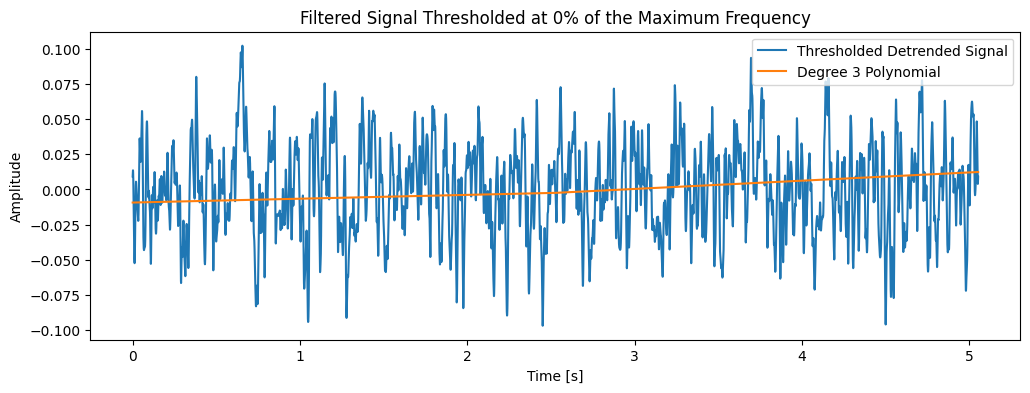

In [85]:
# Defining a Polynomial Regression to identify if the data is detrended.
x = time
y = np.fft.ifft(fft_filter_custom(percentage, freq_bins, FFT))
z = np.polyfit(x, y, 8)
p = np.poly1d(z)
polynomial_degree = 3
xp = np.linspace(0, time[-1], polynomial_degree)

percentage = .0
plt.figure(figsize=(12, 4))
# plt.plot(time, detrend_y, label='Raw Neural Signal',
#          color=list(mcolors.TABLEAU_COLORS.keys())[1])
plt.plot(x, y, 
         color=list(mcolors.TABLEAU_COLORS.keys())[0],
         label='Thresholded Detrended Signal')  
plt.plot(xp, p(xp), color=list(mcolors.TABLEAU_COLORS.keys())[1],
                               label='Degree %i Polynomial'% polynomial_degree)

plt.title('Filtered Signal Thresholded at %0.0f%% of the Maximum Frequency'
          % (percentage*100))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

In [32]:
print(time_filtered_custom.shape)
print(time.shape)

(98699,)
(98699,)


In [31]:
time_filtered_custom_bytes = time_filtered_custom.tobytes()

## Fitting a Polynomial Regression to the data to identify trend

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_1538/3188879593.py:6: RankWarning: Polyfit may be poorly conditioned
  p30 = np.poly1d(np.polyfit(x, y, 30))


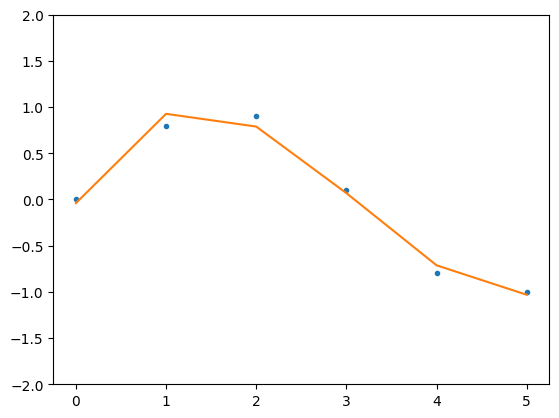

In [54]:
x = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
z = np.polyfit(x, y, 3)

p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(x, y, 30))

xp = np.linspace(-2, 6, 100)
_ = plt.plot(x, y, '.')
plt.plot( x, p(x), '-')
# plt.plot(xp, p30(xp), '--')
plt.ylim(-2,2)
plt.show()



## [Identifying the optimal threshold at which to filter the signal](https://towardsdatascience.com/noise-cancellation-with-python-and-fourier-transform-97303314aa71)

In [ ]:
type(freq_bins)

In [6]:
SAMPLE_RATE = 20000
raw_neural_data, sr = librosa.load(data_file_list[0], sr = SAMPLE_RATE)

# It appears there is a trend in the data that is non-zero
detrend_y = scipy.signal.detrend(raw_neural_data)

# FFT = np.fft.fft(detrend_y)
FFT = np.fft.fft(detrend_y)
half_length_of_the_FFT = int(len(FFT)/2)

# Creating frequency bins
N = len(FFT)

freq_bins = np.arange(start=0, stop=(sr/2), step=(sr/N))

def fft_filter_custom(percentage, freq_bins, FFT):
    threshold = percentage * (2 * abs(FFT[0:len(FFT)//2]) / len(freq_bins)
                              ).max()
    # print(f"threshold: {threshold}")
    filtered_FFT = FFT.copy()
    filtered_FFT_mag = np.abs(filtered_FFT)
    filtered_FFT_mag = 2*filtered_FFT_mag / len(freq_bins)
    filtered_FFT[filtered_FFT_mag <= threshold]=0
    return filtered_FFT

percentage_list = np.linspace(0, 1, num=1000)

p_values = []
correlation_values = []
for percentage in percentage_list:
    fft_filtered_custom = fft_filter_custom(percentage, freq_bins, FFT)    
    filtered_signal = np.fft.ifft(fft_filtered_custom)
    residuals = stats.spearmanr(detrend_y, detrend_y - filtered_signal)
    p_values.append(residuals.pvalue)
    correlation_values.append(residuals.correlation)


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.scatter(percentage_list, correlation_values, s=2, color='tab:green')
plt.title('Correlation between Filtered Signal and Detrended Signal')
plt.ylabel('Correlation Value')
plt.xlabel('Percentage of Filter')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 2)
plt.plot(percentage_list,p_values)
plt.title('Significance of the Correlations')
plt.ylabel('P-Value')
plt.xlabel('Percentage of Filter')
